One Class Diagonal Translation. 2 Dimensional data.
100 batches of 152 instances



METHOD: Static lp as classifier
Execution time:  0.44110472032164383
Average MCC:  0.987307346672
Average macro-F1: 0.9935420453769157
Average Accuracy:  99.2486
Standard Deviation:  0.761910782179
Variance:  0.58050804


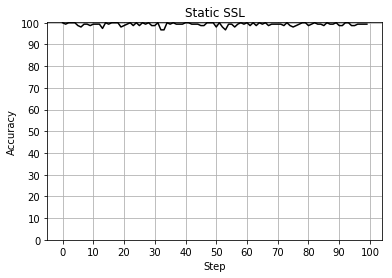

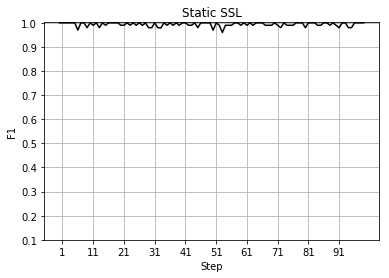




METHOD: Sliding lp as classifier
Execution time:  0.4093124851110934
Average MCC:  0.99900379101
Average macro-F1: 0.9994968836583773
Average Accuracy:  99.9341
Standard Deviation:  0.254868966334
Variance:  0.06495819


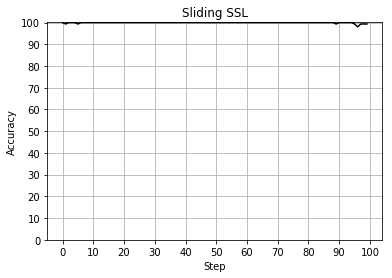

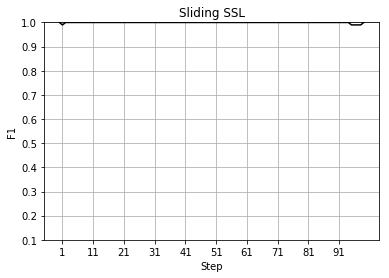




METHOD: Incremental lp as classifier
Execution time:  4.901475043723508
Average MCC:  0.994444010306
Average macro-F1: 0.9971842043316437
Average Accuracy:  99.7098
Standard Deviation:  0.449988844306
Variance:  0.20248996


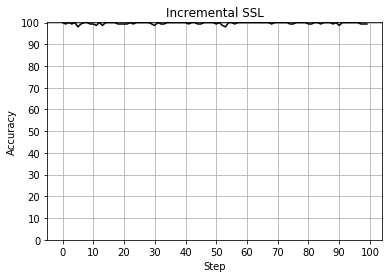

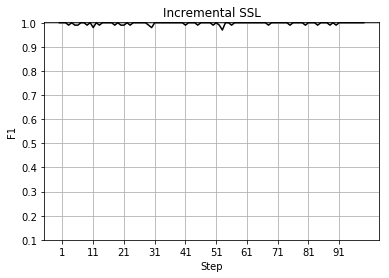




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  0.8345428162482769
Average MCC:  0.999602503511
Average macro-F1: 0.9997992569606109
Average Accuracy:  99.9802
Standard Deviation:  0.112587565921
Variance:  0.01267596


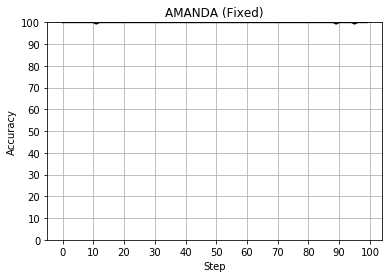

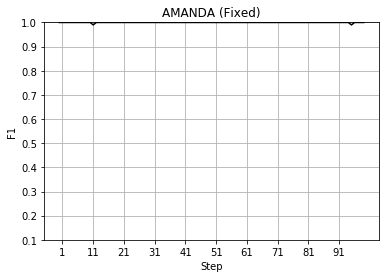




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
Execution time:  0.8178605248717332
Average MCC:  0.999007922444
Average macro-F1: 0.9994969856817747
Average Accuracy:  99.9538
Standard Deviation:  0.192534568325
Variance:  0.03706956


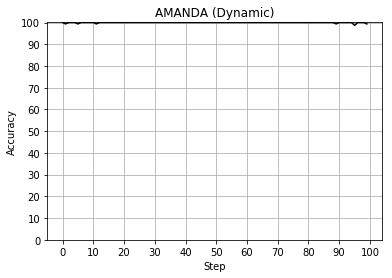

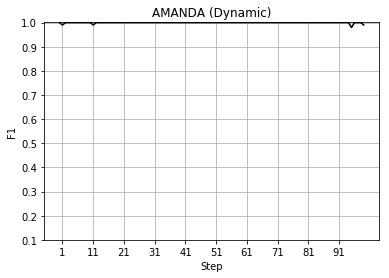




METHOD: None as classifier and GMM with BIC and Mahalanobis as core support extraction
Execution time:  23.685668368199547
Average MCC:  0.99921073201
Average macro-F1: 0.999597423510467
Average Accuracy:  99.9209
Standard Deviation:  0.31287727626
Variance:  0.09789219


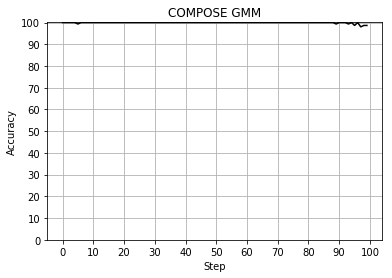

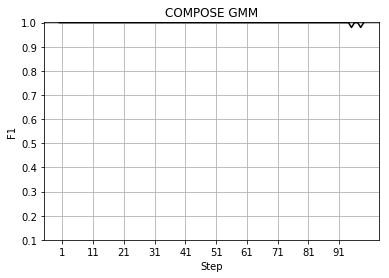




Method: Level IW
Execution time:  23.685668368199547
Average MCC:  -0.000156268648432
Average macro-F1: 0.4972992852476316
Average Accuracy:  99.967105
Standard Deviation:  0.170927433945
Variance:  0.029216187675


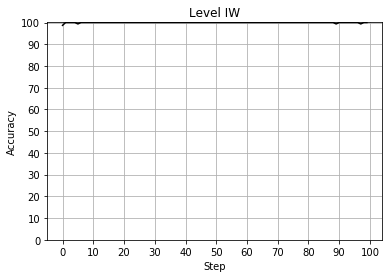

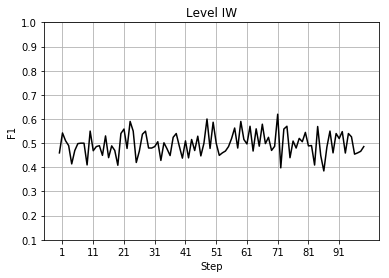

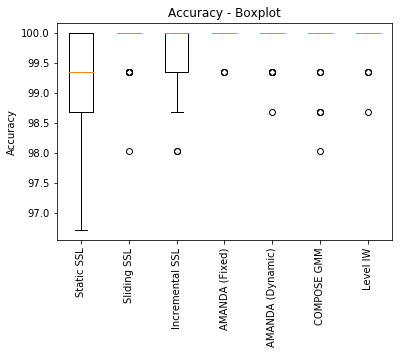

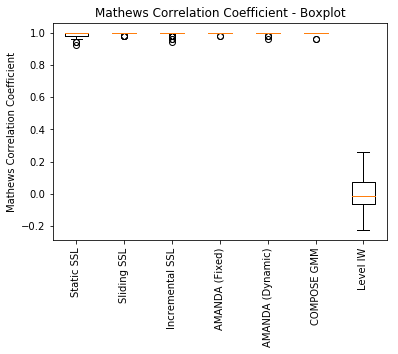

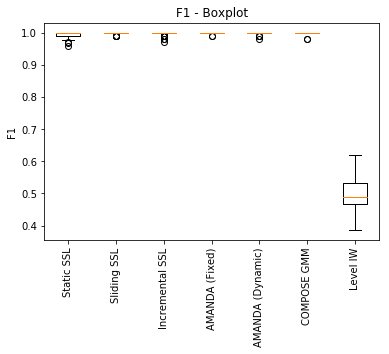

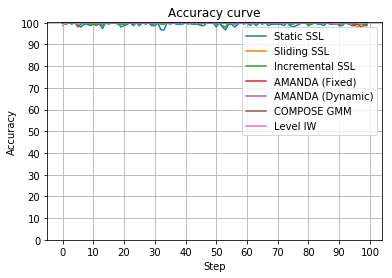

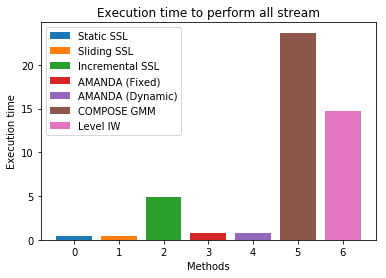

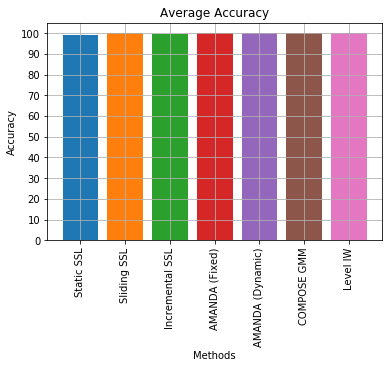

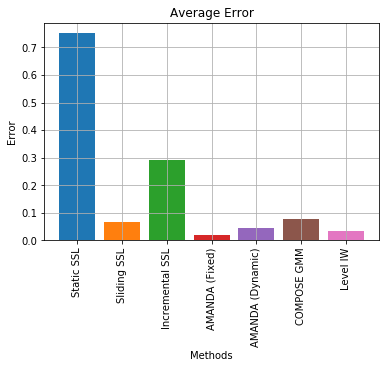

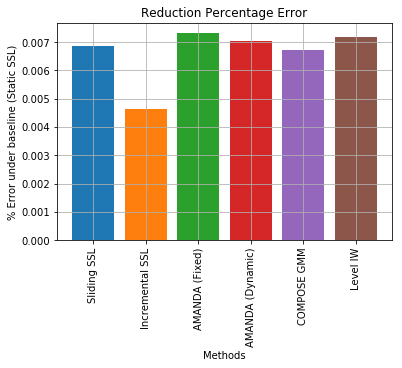

In [1]:
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[3])

import setup
import numpy as np
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version
#from methods import lstm


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ np.asarray(predictions[i::steps]) for i in range(steps) ]
    
    #print("predictions",np.shape(predictions))
    #print("originalAccs",key,originalAccs[key])
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, nb = naive bayes, knn = k-nn, sgd = stochastic gradient descent
    steps = 100
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = True
    isImbalanced = False
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadCDT(path, sep)
    
    # Only 5% of initial labeled data - Extreme verification latency scenario
    labeledData = int(0.05*len(dataLabels))
    #'''
    # Static SSL
    experiments[0] = Experiment(static_classifier, 2, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 2, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 2, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 2, 0.85, "kde", clfName=sslClassifier)

    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    experiments[4] = Experiment(amanda_dynamic, 4, None, "kde", clfName=sslClassifier)

    # COMPOSE GMM (Python version)
    experiments[5] = Experiment(compose_gmm_version, 2)
    
    # levelIw matlab results
    predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, '1CDT', steps)
    externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    #'''
    # Upper-bound
    #experiments[6] = Experiment(lstm, 2)
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()